In [4]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook
%pwd

'/mnt/c/Users/mtr22/Code/mre-pinn/notebooks'

In [5]:
import sys, os, itertools
import numpy as np
import scipy
#import sfepy
import torch
import matplotlib.pyplot as plt

sys.path.append('..')
%aimport mre_pinn

Using backend: pytorch



# 1D Poisson forward FEM

Following FEM wikipedia page we have for $u: [-1, 1] \to \mathbb{R}$ and $f: [-1, 1] \to \mathbb{R}$:

$$
\begin{align}
    u''(x) &= f(x) \\
    u(-1) &= 0 \\
    u(1) &= 0
\end{align}
$$

We are given $f$ and the above PDE and boundary conditions, and we would like to solve for $u$.

Variational form:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= \int_{-1}^1 f(x)v(x) dx \quad \forall v
\end{align}
$$

Integration by parts:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx \\
    \int_{-1}^1 u''(x)v(x) dx &= - \int_{-1}^1 u'(x)v'(x) dx \\
    - \int_{-1}^1 u'(x)v'(x) dx &= \int_{-1}^1 f(x)v(x) dx \\
    \int_{-1}^1 u'(x)v'(x) dx &= -\int_{-1}^1 f(x)v(x) dx
\end{align}
$$

Domain discretization by 1D uniform mesh with $n$ nodes, for $i = [0, 1, ..., n - 1]$:

$$
    x_i = \frac{i}{n - 1}
$$

Basis functions:

$$
\begin{align}
    u(x) = \sum_{i=0}^{n - 1} u_i \phi_i(x) \\
    f(x) = \sum_{i=0}^{n - 1} f_i \phi_i(x) \\
    v(x) = \sum_{i=0}^{n - 1} v_i \phi_i(x)
\end{align}
$$

Substitute and derive:

$$
\begin{align}
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j'(x) dx &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi'_i(x) \right) \phi_j'(x) dx &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \sum_{i=0}^{n - 1} u_i \phi'_i(x) \phi_j'(x) dx &= -\int_0^1 \sum_{i=0}^{n - 1} f_i \phi_i(x) \phi_j(x) dx \\
    \sum_{i=0}^{n - 1} u_i \left(\int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) &= -\sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1 \phi_i(x) \phi_j(x) dx \right)
\end{align}
$$

Assemble FEM matrices:

$$
\begin{align}
    \mathbf{K}_{ij} &= \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \\
    \mathbf{M}_{ij} &= \int_{-1}^1 \phi_i(x) \phi_j(x) dx
\end{align}
$$

Linear system:

$$
    \mathbf{K} \mathbf{u} = -\mathbf{M} \mathbf{f}
$$

In [38]:
# define the basis function

def psi(x, nodes, radius=1):
    '''
    Evaluate piecewise linear basis functions.
    
    Args:
        x: (N, D) array of positions to evaluate.
        nodes: (M, D) array of node locations.
        radius: Scalar radius of basis functions.
    Returns:
        (M, N) array of basis function values.
    '''
    nax = np.newaxis
    diff = (nodes[:,nax] - x[nax,:]) / radius
    dist = torch.norm(diff, np.inf, dim=2)
    return torch.clamp(1 - dist, min=0)

<IPython.core.display.Javascript object>


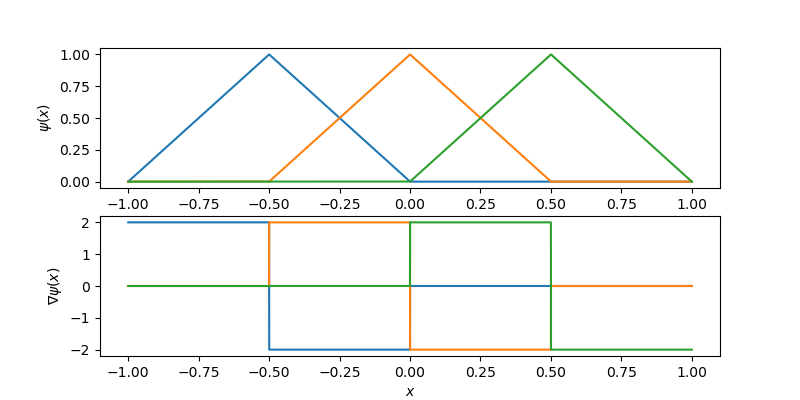

Text(0.5, 0, '$x$')

In [39]:
# define the mesh (number of basis functions)
ndim = 1
n_nodes = 5
nax = np.newaxis
nodes = torch.linspace(-1, 1, n_nodes)[:,nax]

# mesh resolution
d_node = nodes[1] - nodes[0]

# remove boundary nodes
nodes = nodes[1:-1]
n_nodes = len(nodes)

# domain samples (integral resolution)
n_samples = 50001
x = torch.linspace(-1, 1, n_samples)[:,nax]
x.requires_grad = True

# sample resolution
dx = x[1] - x[0]

psi_x = psi(x, nodes, d_node)

# evaluate gradient of each basis function
grad_psi_x = torch.zeros((n_nodes**ndim, n_samples**ndim, ndim))
for i in range(n_nodes**ndim):
    grad_psi_x[i] = torch.autograd.grad(psi_x[i], x, torch.ones_like(psi_x[i]), retain_graph=True)[0]
    
fig, axes = plt.subplots(2, 1, figsize=(8,4))
axes[0].plot(x.detach().cpu().numpy(), psi_x.detach().cpu().numpy().T, label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), grad_psi_x.detach().cpu().numpy()[...,0].T, label=range(n_nodes))
axes[0].set_ylabel(r'$\psi(x)$')
axes[1].set_ylabel(r'$\nabla\psi(x)$')
axes[1].set_xlabel(r'$x$')

In [37]:
# assemble FEM matrices

# compute basis function products needed for variational form of PDE
M_products = (psi_x[:,nax,:] * psi_x[nax,:,:])
K_products = (grad_psi_x[:,nax,...] * grad_psi_x[nax,:,...]).sum(dim=-1)

# Riemann integrals of basis function products
M = (M_products * dx).sum(dim=-1)
K = (K_products * dx).sum(dim=-1)

M, K

(tensor([[0.3333, 0.0833, 0.0000],
         [0.0833, 0.3333, 0.0833],
         [0.0000, 0.0833, 0.3333]], grad_fn=<SumBackward1>),
 tensor([[ 3.9996e+00, -1.9994e+00, -1.5998e-04],
         [-1.9994e+00,  3.9995e+00, -1.9997e+00],
         [-1.5998e-04, -1.9997e+00,  3.9995e+00]], grad_fn=<SumBackward1>))

In [40]:
def f(x):
    '''True forcing function.'''
    return -2 * torch.ones_like(x)

def u(x):
    '''True displacement function.'''
    return 1 - x**2

# sample forcing function on mesh and over full domain
f_h = f(nodes)
f_x = f(x)

# sample true displacement function on mesh and over full domain
u_h = u(nodes)
u_x = u(x)

# solve linear system of equations
uhat_h = torch.linalg.solve(K, -M @ f_h)

# linear combination of basis functions
uhat_psi_x = (uhat_h * psi_x)
uhat_x = uhat_psi_x.sum(dim=0, keepdim=True).T

uhat_h

tensor([[0.6665],
        [0.9165],
        [0.6666]], grad_fn=<LinalgSolveBackward0>)

<IPython.core.display.Javascript object>


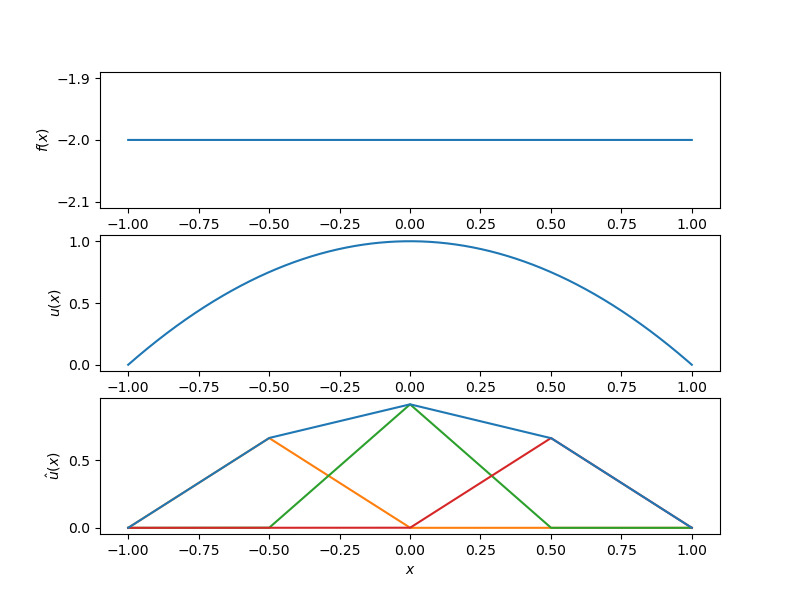

Text(0.5, 0, '$x$')

In [35]:


fig, axes = plt.subplots(3, 1, figsize=(8,6))
axes[0].plot(x.detach().cpu().numpy(), f_x.detach().cpu().numpy(), label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), uhat_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), uhat_psi_x.detach().cpu().numpy().T, label=range(n_nodes), zorder=0)
axes[0].set_ylabel(r'$f(x)$')
axes[1].set_ylabel(r'$u(x)$')
axes[2].set_ylabel(r'$\hat{u}(x)$')
axes[-1].set_xlabel(r'$x$')

# 1D Poisson inverse FEM

Similar problem setup as before:

$$
\begin{align}
    u''(x) &= f(x) \\
    u(-1) &= 0 \\
    u(1) &= 0
\end{align}
$$

But now we are given $u$ and we want to infer the forcing function $f$.

Variational form is the same:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= \int_{-1}^1 f(x)v(x) dx \quad \forall v
\end{align}
$$

Integration by parts (note we cannot drop the boundary integral now, since $v$ is in the same space as $f$, which may not be zero on the boundary):

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx \\
    u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx &= \int_{-1}^1 f(x)v(x) dx \\
    \int_{-1}^1 u'(x)v'(x) dx - u'(x)v(x) \vert_{-1}^1 &= -\int_{-1}^1 f(x)v(x) dx
\end{align}
$$

Domain discretization by 1D uniform mesh with $n$ nodes, for $i = [0, 1, ..., n - 1]$:

$$
    x_i = \frac{i}{n - 1}
$$

Basis functions:

$$
\begin{align}
    u(x) = \sum_{i=0}^{n - 1} u_i \phi_i(x) \\
    f(x) = \sum_{i=0}^{n - 1} f_i \phi_i(x) \\
    v(x) = \sum_{i=0}^{n - 1} v_i \phi_i(x)
\end{align}
$$

Substitute and derive:

$$
\begin{align}
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j'(x) dx - {\left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j(x)} \vert_{-1}^1 &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi'_i(x) \right) \phi_j'(x) dx - \left( \sum_{i=0}^{n - 1} u_i \phi_i'(x) \right) \phi_j(x) \vert_{-1}^1 &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \sum_{i=0}^{n - 1} u_i \phi'_i(x) \phi_j'(x) dx - \sum_{i=0}^{n - 1} u_i \phi_i'(x) \phi_j(x) \vert_{-1}^1 &= -\int_{-1}^1 \sum_{i=0}^{n - 1} f_i \phi_i(x) \phi_j(x) dx \\
    \sum_{i=0}^{n - 1} u_i \left[ \left( \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) - \phi_i'(x) \phi_j(x) \vert_{-1}^1 \right] &= -\sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1  \phi_i(x) \phi_j(x) dx \right) \\
    \sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1  \phi_i(x) \phi_j(x) dx \right) &= \sum_{i=0}^{n - 1} u_i \left[ \phi_i'(x) \phi_j(x) \vert_{-1}^1 - \left( \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) \right]
\end{align}
$$

Assemble FEM matrices:

$$
\begin{align}
    \mathbf{M}_{ij} &= \int_{-1}^1 \phi_i(x) \phi_j(x) dx \\
    \mathbf{K}_{ij} &= \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \\
    \mathbf{T}_{ij} &= \phi_i'(x) \phi_j(x) \vert_{-1}^1
\end{align}
$$

Linear system:

$$
    \mathbf{M} \mathbf{f} = \left( \mathbf{T} - \mathbf{K} \right) \mathbf{u}
$$

<IPython.core.display.Javascript object>


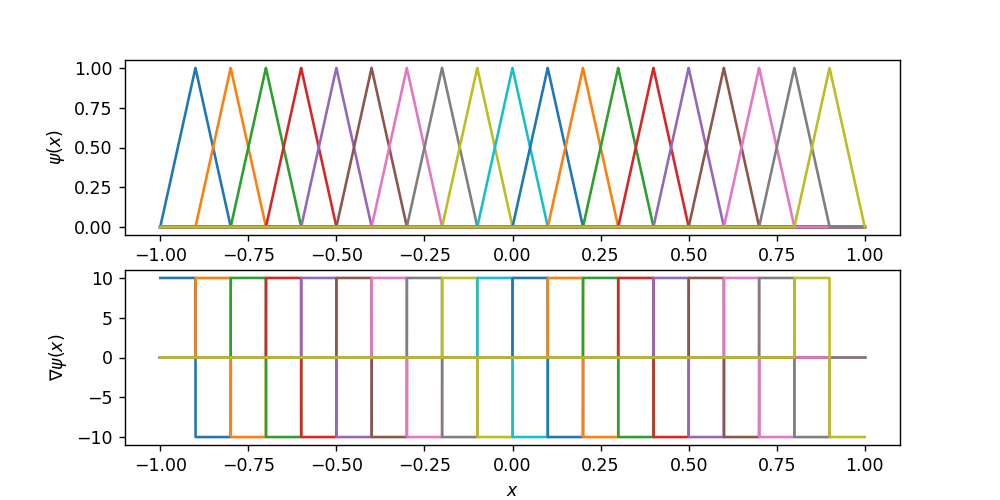

Text(0.5, 0, '$x$')

In [6]:
# define the mesh
ndim = 1
n_nodes = 21
nax = np.newaxis
nodes = torch.linspace(-1, 1, n_nodes)[:,nax]

# mesh resolution
d_node = nodes[1] - nodes[0]

# remove boundary nodes
nodes = nodes[1:-1]
n_nodes -= 2

# domain samples
n_samples = 40001
x = torch.linspace(-1, 1, n_samples)[:,nax]
x.requires_grad = True

# sample resolution
dx = x[1] - x[0]

psi_x = psi(x, nodes, d_node)

# evaluate gradient of each basis function
grad_psi_x = torch.zeros((n_nodes**ndim, n_samples**ndim, ndim))
for i in range(n_nodes**ndim):
    grad_psi_x[i] = torch.autograd.grad(psi_x[i], x, torch.ones_like(psi_x[i]), retain_graph=True)[0]
    
fig, axes = plt.subplots(2, 1, figsize=(8,4))
axes[0].plot(x.detach().cpu().numpy(), psi_x.detach().cpu().numpy().T, label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), grad_psi_x.detach().cpu().numpy()[...,0].T, label=range(n_nodes))
axes[0].set_ylabel(r'$\psi(x)$')
axes[1].set_ylabel(r'$\nabla\psi(x)$')
axes[1].set_xlabel(r'$x$')

We will now assemble the FEM matrices, but we need to include a traction matrix:
    
$$
\begin{align}
    \mathbf{T}_{ij} &= \phi_i'(x) \phi_j(x) \vert_{-1}^1 \\
    \mathbf{T}_{ij} &= \phi_i'(1) \phi_j(1) - \phi_i'(-1) \phi_j(-1) \\
    \mathbf{T}_{ij} &= \int_\Gamma n\phi_i'(x) \phi_j(x) dx \\
\end{align}
$$

Where $n$ is the boundary normal, i.e. $n = 1$ for the right boundary and $n = -1$ for the left boundary.

In [7]:
# get the boundary normals
normal = torch.zeros(n_samples, ndim)
left_boundary = (x[:,0] == -1)
right_boundary = (x[:,0] == 1)
normal[left_boundary,0] = -1
normal[right_boundary,0] = 1
normal.shape

torch.Size([40001, 1])

In [8]:
# compute basis function products and integrals

M_products = (psi_x[:,nax,:] * psi_x[nax,:,:])
T_products = (psi_x[:,nax,:,nax] * grad_psi_x[nax,:] * normal[nax,nax]).sum(dim=-1) # dot product
K_products = (grad_psi_x[:,nax,...] * grad_psi_x[nax,:,...]).sum(dim=-1) # dot product

# simple Riemannian integration
M = (M_products * dx).sum(dim=-1)
T = (T_products).sum(dim=-1)
K = (K_products * dx).sum(dim=-1)

print(M.shape, T.shape, K.shape)

torch.Size([19, 19]) torch.Size([19, 19]) torch.Size([19, 19])


<IPython.core.display.Javascript object>


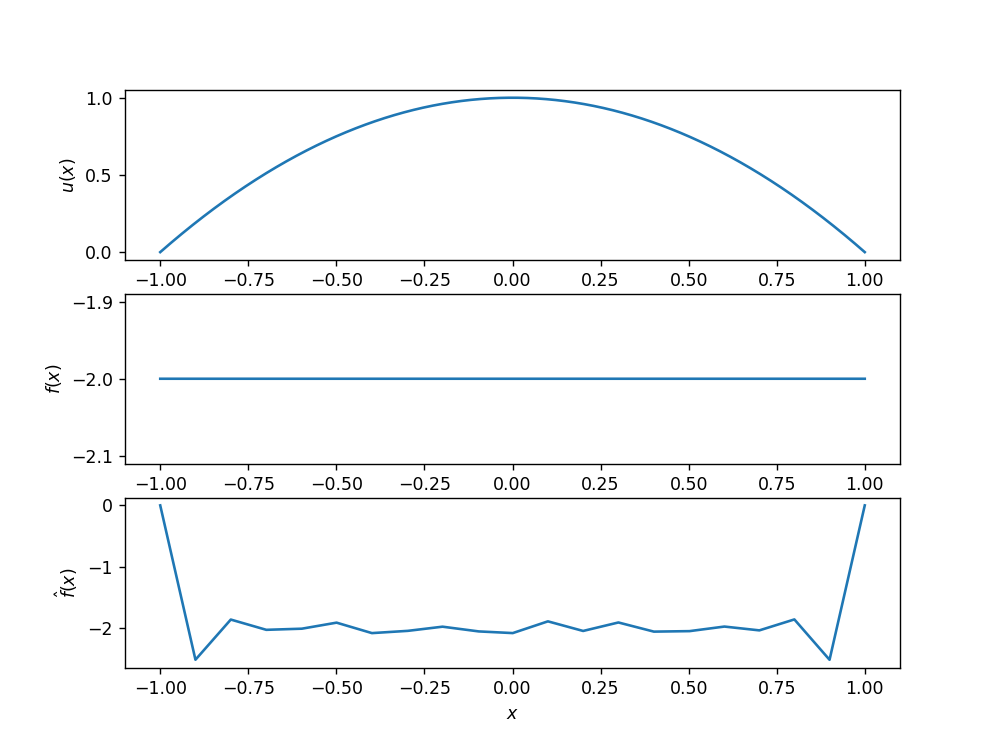

Text(0.5, 0, '$x$')

In [9]:
def f(x):
    '''True forcing function.'''
    return -2 * torch.ones_like(x)

def u(x):
    '''True displacement function.'''
    return 1 - x**2

# sample forcing function on mesh and over full domain
f_h = f(nodes)
f_x = f(x)

# sample true displacement function on mesh and over full domain
u_h = u(nodes)
u_x = u(x)

# solve linear system of equations
fhat_h = torch.linalg.solve(M, -K @ u_h)

# linear combination of basis functions
fhat_psi_x = (fhat_h * psi_x)
fhat_x = fhat_psi_x.sum(dim=0, keepdim=True).T

fig, axes = plt.subplots(3, 1, figsize=(8,6))
axes[0].plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), f_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), fhat_x.detach().cpu().numpy(), label=range(n_nodes))
#axes[2].plot(x.detach().cpu().numpy(), fhat_psi_x.detach().cpu().numpy().T, label=range(n_nodes), zorder=0)
axes[0].set_ylabel(r'$u(x)$')
axes[1].set_ylabel(r'$f(x)$')
axes[2].set_ylabel(r'$\hat{f}(x)$')
axes[-1].set_xlabel(r'$x$')